# Experimentation with using the Data containers in PyMC3

In [1]:
import string
from time import time
from typing import Any, Dict

import arviz as az
import common_data_processing as dphelp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
from numpy.random import normal as rnorm

notebook_tic = time()

%matplotlib inline
%config InlineBackend.figure_format = "retina"
gg.theme_set(gg.theme_minimal)

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

## Resources

- [Prior and Posterior Predictive Checks](https://docs.pymc.io/notebooks/posterior_predictive.html)
- [Using shared variables (Data container adaptation)](https://docs.pymc.io/notebooks/data_container.html)
- [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html)

## Basic example

The data container wraps around the Theano shared variable class and lets the model be aware of its inputs and outputs.
Below is an example of a hierarchical model on fake weather data.

In [2]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-05-20")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = np.random.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

,Berlin,San Marino,Paris
date,,,
2020-05-01,14.708568,18.905539,15.230894
2020-05-02,13.729669,17.359776,16.461333
2020-05-03,15.919799,17.766166,15.369512
2020-05-04,17.294473,17.685680,14.724499
2020-05-05,14.661021,18.648179,17.882056


In [3]:
coords = {"date": df_data.index, "city": df_data.columns}

with pm.Model(coords=coords) as model:
    europe_mean = pm.Normal("europe_mean_temp", 15.0, 3.0)
    city_offset = pm.Normal("city_offset", 0.0, 3.0, dims="city")
    city_temperature = pm.Deterministic(
        "city_temperature", europe_mean + city_offset, dims="city"
    )

    data = pm.Data("data", df_data, dims=("date", "city"))
    y = pm.Normal("likelihood", mu=city_temperature, sd=0.5, observed=data)

    idata = pm.sample(
        2000,
        tune=2000,
        target_accept=0.85,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [city_offset, europe_mean_temp]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [4]:
model.coords

{'date': DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
                '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
                '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
                '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
                '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20'],
               dtype='datetime64[ns]', name='date', freq='D'),
 'city': Index(['Berlin', 'San Marino', 'Paris'], dtype='object')}

In [5]:
idata.posterior.coords

Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * city     (city) object 'Berlin' 'San Marino' 'Paris'

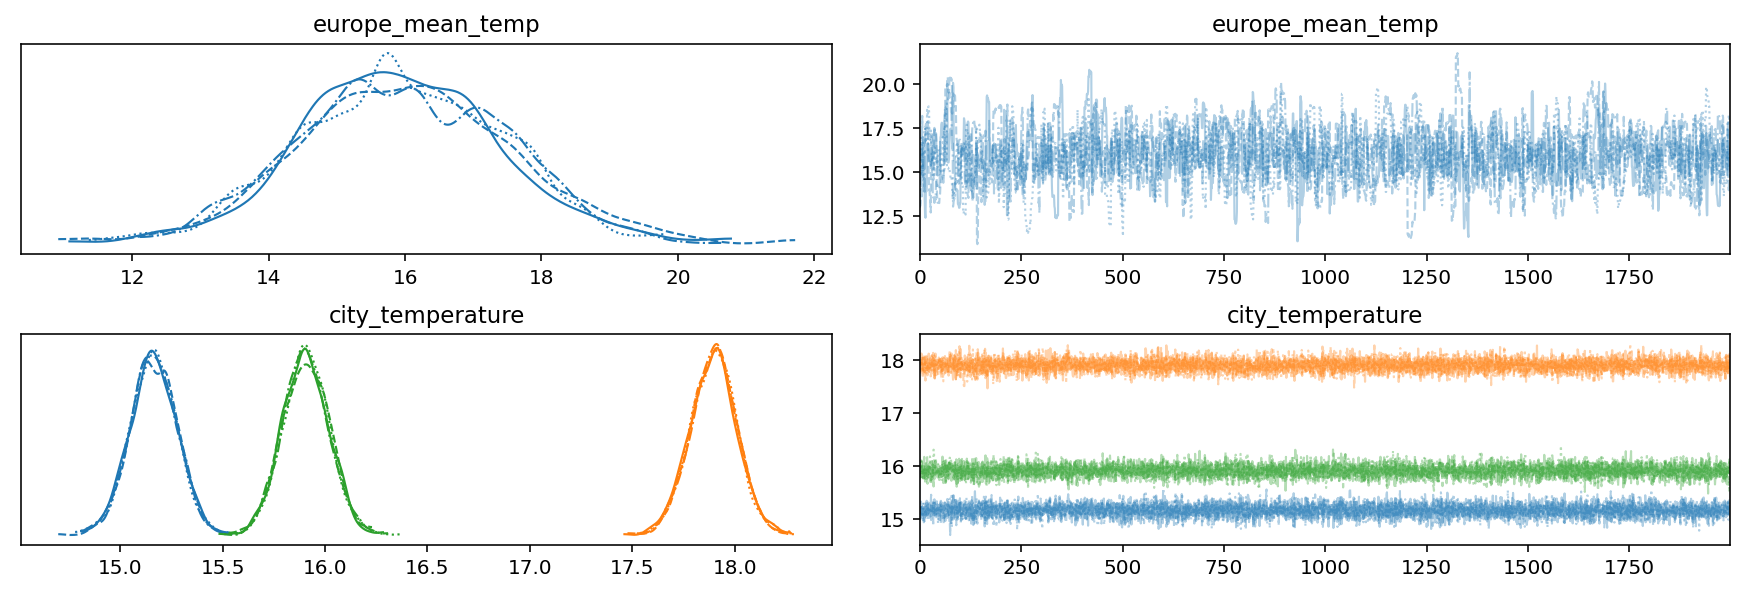

In [6]:
az.plot_trace(idata, var_names=["europe_mean_temp", "city_temperature"])
plt.show()

## Predicting on new data

In [7]:
x = np.random.randn(100)
y = x > 0

with pm.Model() as model:
    x_shared = pm.Data("x_shared", x)

    coeff = pm.Normal("x", 0, 1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    yi = pm.Bernoulli("obs", p=logistic, observed=y)

    trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [8]:
new_x_values = [-1.0, 0.0, 1.0]

with model:
    pm.set_data({"x_shared": new_x_values})
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


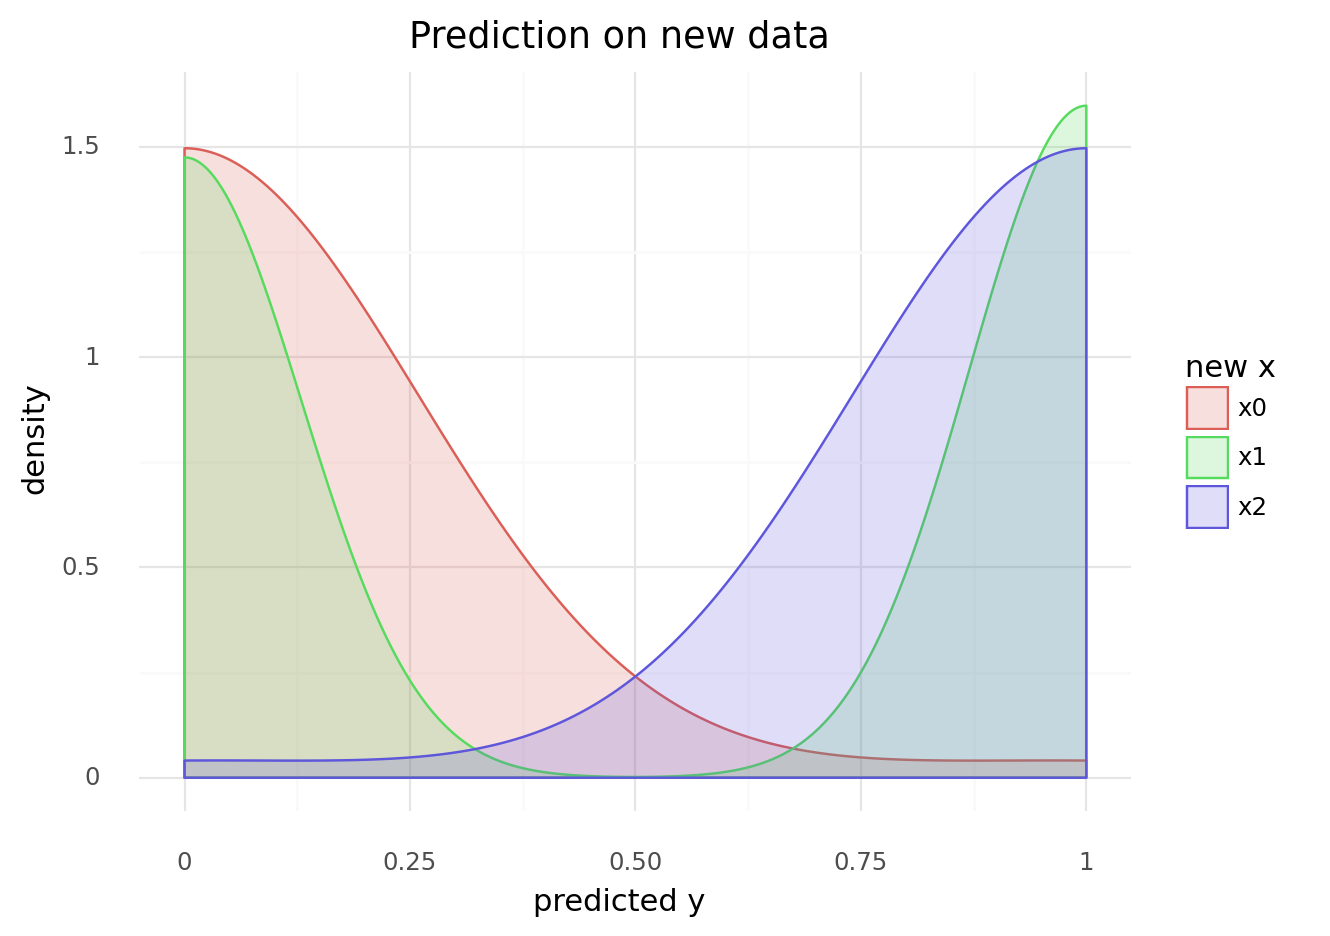

<ggplot: (8776007919879)>

In [9]:
post_df = pd.DataFrame(
    post_pred["obs"], columns=[f"x{i}" for i in range(len(new_x_values))]
).melt()

(
    gg.ggplot(post_df, gg.aes(x="value"))
    + gg.geom_density(gg.aes(color="variable", fill="variable"), alpha=0.2)
    + gg.labs(
        x="predicted y", color="new x", fill="new x", title="Prediction on new data"
    )
)

## Example with hierarhcical model

$$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_i + \beta_i X \\
\alpha_i \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 5) \quad \sigma_\alpha \sim \text{HalfNormal}(5) \\
\beta_i \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\mu_\beta \sim \mathcal{N}(0, 5) \quad \sigma_\beta \sim \text{HalfNormal}(5) \\
\sigma \sim \text{HalfNormal}(5)
$$

In [10]:
np.random.seed(RANDOM_SEED)

real_params: Dict[str, Any] = {"μ_α": 1, "σ_α": 0.5, "μ_β": -2, "σ_β": 1, "σ": 0.3}

n_groups = 5
real_params["α_i"] = rnorm(real_params["μ_α"], real_params["σ_α"], n_groups)
real_params["β_i"] = rnorm(real_params["μ_β"], real_params["σ_β"], n_groups)


data_list = []
for _ in range(120):
    i = np.random.choice(range(n_groups))
    x = rnorm(0, 1)
    mu = real_params["α_i"][i] + real_params["β_i"][i] * x
    y = rnorm(mu, real_params["σ"], 1)

    d = pd.DataFrame(
        {"group": list(string.ascii_uppercase)[i], "group_idx": i, "x": x, "y": y}
    )
    data_list.append(d)

data = pd.concat(data_list[:100]).reset_index(drop=True)
data = dphelp.make_cat(data, "group", sort_cats=True)

new_data = pd.concat(data_list[100:]).reset_index(drop=True)
new_data = dphelp.make_cat(new_data, "group", sort_cats=True)

data.head()

,group,group_idx,x,y
0,B,1,-1.253461,-0.021794
1,B,1,-0.130462,0.606251
2,E,4,-1.026225,2.458372
3,B,1,-1.221319,0.121444
4,C,2,0.389152,-0.202663


In [11]:
def extract_data(s: pd.Series) -> np.ndarray:
    return s.to_numpy().flatten()


coords = {"groups": data.sort_values("group").group.unique().to_numpy()}

with pm.Model(coords=coords) as model:
    x_shared = pm.Data("x_shared", extract_data(data.x))
    y_shared = pm.Data("y_shared", extract_data(data.y))
    group_idx = pm.Data("group_idx", extract_data(data.group_idx).astype(int))

    μ_α = pm.Normal("μ_α", 0, 5)
    σ_α = pm.HalfNormal("σ_α", 5)
    μ_β = pm.Normal("μ_β", 0, 5)
    σ_β = pm.HalfNormal("σ_β", 5)

    α_i = pm.Normal("α_i", μ_α, σ_α, dims="groups")
    β_i = pm.Normal("β_i", μ_β, σ_β, dims="groups")

    μ = pm.Deterministic("μ", α_i[group_idx] + β_i[group_idx] * x_shared)
    σ = pm.HalfNormal("σ", 5)

    y_i = pm.Normal("y_i", μ, σ, observed=y_shared)

    trace = pm.sample(random_seed=RANDOM_SEED, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_i, α_i, σ_β, μ_β, σ_α, μ_α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [12]:
var_names = ["μ_α", "σ_α", "μ_β", "σ_β", "α_i", "β_i"]
az.summary(trace, var_names=var_names, kind="stats", hdi_prob=0.89)

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


,mean,sd,hdi_5.5%,hdi_94.5%
μ_α,1.050,0.493,0.313,1.803
σ_α,0.991,0.537,0.353,1.604
μ_β,-2.076,1.136,-3.837,-0.345
σ_β,2.387,1.124,0.959,3.674
α_i[0],0.805,0.070,0.690,0.910
α_i[1],0.321,0.072,0.198,0.430
α_i[2],1.469,0.062,1.372,1.568
α_i[3],1.969,0.069,1.855,2.077
α_i[4],0.785,0.060,0.689,0.885
β_i[0],-3.385,0.041,-3.453,-3.321


In [13]:
with model:
    pm.set_data(
        {
            "x_shared": extract_data(new_data.x),
            "group_idx": extract_data(new_data.group_idx).astype(int),
        }
    )

    predictions = pm.sample_posterior_predictive(trace, samples=500)

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


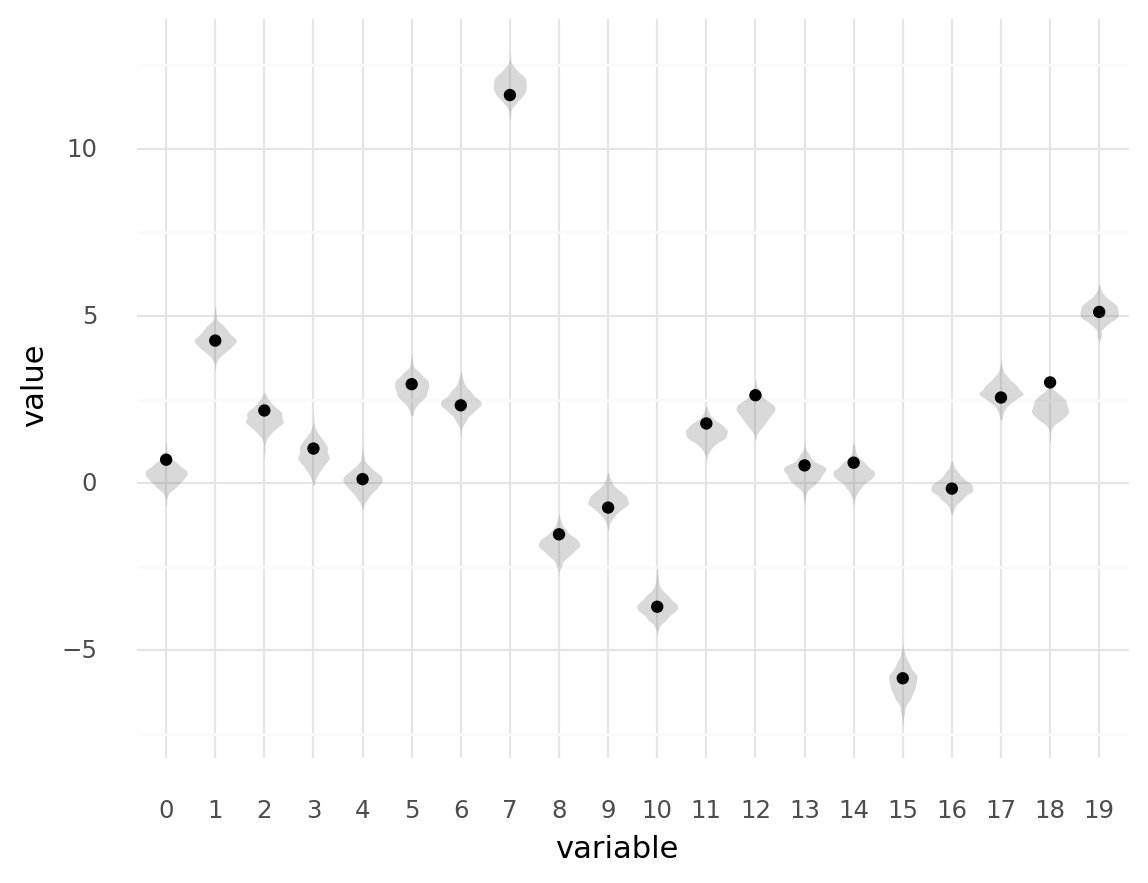

<ggplot: (8775976930205)>

In [14]:
new_pred_df = pd.DataFrame(predictions["y_i"]).melt()
new_pred_df = dphelp.make_cat(new_pred_df, "variable", ordered=True)

new_data = new_data.reset_index(drop=False)
new_data = dphelp.make_cat(new_data, "index", ordered=True)

(
    gg.ggplot(new_pred_df, gg.aes(x="variable", y="value"))
    + gg.geom_violin(color=None, alpha=0.3, fill="grey")
    + gg.geom_point(gg.aes(x="index", y="y"), data=new_data)
)

---

In [15]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.80 minutes


In [16]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-20

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-235.o2.rc.hms.harvard.edu

Git branch: data-subset-model

matplotlib: 3.3.3
plotnine  : 0.7.1
pymc3     : 3.9.3
pandas    : 1.2.0
numpy     : 1.19.5
arviz     : 0.11.0

